In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
import cv2
from tqdm import tqdm
%matplotlib inline

In [2]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

True
True
cuda


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [4]:
data0 = np.load('data0.npy')
data1 = np.load('data1.npy')
data2 = np.load('data2.npy')
lab0 = np.load('lab0.npy')
lab1 = np.load('lab1.npy')
lab2 = np.load('lab2.npy')

In [5]:
total_data= np.concatenate([data0, data1, data2], axis=0)
total_labels= np.concatenate([lab0, lab1, lab2], axis=0)

# Utility functions for processing images before feeding them to MNIST model

In [6]:
def padd_img(img):
    w,h = img.shape
    new_img = np.pad(img, pad_width = ((4,4),(6 ,6)), mode = 'constant')
    new_img = cv2.resize(new_img, (28,28))
    return new_img

In [7]:
def break_img(img):
    a= img[:,:14]
    b = img[:,14:]
    return a, b

In [8]:
def all_digits(img):
    ret, thresh = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    (numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(thresh, cv2.CV_32S)
    digits= [] 
    new_digits= []
    for i in range(0,numLabels):
        if i != 0:
            x = stats[i, cv2.CC_STAT_LEFT] -2
            y = stats[i, cv2.CC_STAT_TOP] - 2 
            w = stats[i, cv2.CC_STAT_WIDTH] + 4
            h = stats[i, cv2.CC_STAT_HEIGHT] + 4
            area = stats[i, cv2.CC_STAT_AREA]
            new_img = img[y:y+h+1, x:x+w+1] 
            if area > 20:
                digits.append(new_img)
    if (len (digits) == 3):
        max_ind = 1
        max_area = 0
        for i in range(len(digits)):
            area = digits[i].shape[0] * digits[i].shape[1]
            if (area > max_area):
                max_area =area
                max_ind = i
                
        digit1, digit2 = break_img(padd_img(digits[max_ind]))
        new_digits = [padd_img(digit1), padd_img(digit2)]
        for i in range(len(digits)):
            if (i!=max_ind):
                new_digits.append(padd_img(digits[i]))
        digits = new_digits
    else:
        for i in range(len(digits)):
            new_digits.append(padd_img(digits[i]))
    digits = new_digits
    return np.array(digits)

In [9]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        if torch.cuda.is_available():
            data = data.cuda()
        output = conv_model(data)
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
    return test_preds


# Load Best model so far

In [10]:
conv_model = Net()
conv_model = torch.load('./MODELS/A_BEST_PERF76.38')
# conv_model = torch.load('./MODELS/random_mnist_model.pt')

In [15]:
    
def test_model(test_data, test_labels):
    '''test_data is the numpy array of the test  set'''
    all_preds = []
    for data in tqdm(test_data):
        digits = torch.Tensor(all_digits(data))
        digits = digits.unsqueeze(1).cuda()
        digits = digits / 255.0
        out = conv_model(digits)
        preds = out.cpu().data.max(1, keepdim=True)[1]
        final_pred = np.sum(np.array(preds).flatten())
        all_preds.append(final_pred)
    acc = np.array(all_preds == test_labels).astype(int).mean()
    print( "The accuracy on the set provided is ", acc * 100)
    return all_preds

In [16]:
all_preds = test_model(total_data, total_labels)

100%|██████████| 30000/30000 [03:47<00:00, 132.00it/s]

The accuracy on the set provided is  76.30666666666667


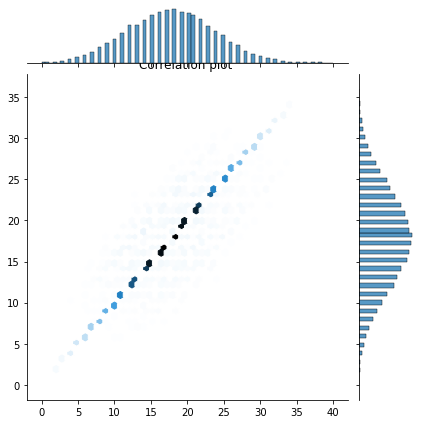

In [22]:
import seaborn as sns
sns.jointplot(x=all_preds, y= total_labels, kind='hex')
plt.title("Correlation plot ")
plt.savefig('Testing_performance.png', dpi= 300)

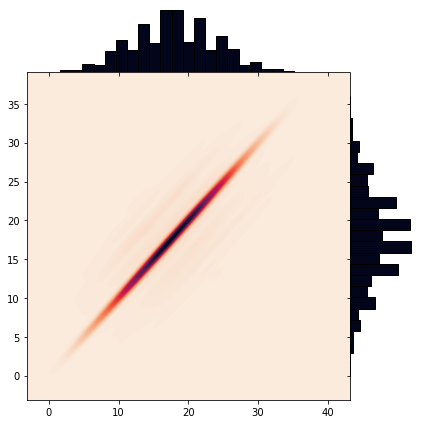

In [23]:
g = sns.JointGrid(x=all_preds, y= total_labels, space=0)
g.plot_joint(sns.kdeplot,
             fill=True,
             thresh=0, levels=100, cmap="rocket_r")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)